# EhV: embedding with PHATE

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [13]:
import anndata
import scanpy
import scanpy.external

In [4]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [5]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])

cols = numpy.load(data_dir / "indices/columns_batch_v2.npy", allow_pickle=True)
cols = numpy.delete(cols, numpy.where(numpy.char.find(cols.astype("str"),"logicle")!=-1))
df = df[cols]

df = df.loc[numpy.load(data_dir / "indices/index_batch_v2.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(44384, 886)

In [6]:
adata = anndata.AnnData(
    df.filter(regex="feat"), 
    obs=pandas.concat([df.filter(regex="meta"), df.index.to_frame()], axis=1),
    dtype=numpy.float32
)
adata.raw = adata

In [7]:
adata.X = adata.to_df().fillna(0)

In [15]:
adata2 = adata.copy()

In [17]:
%%time
scanpy.pp.scale(adata2)
scanpy.external.tl.phate(adata2, knn=30, n_landmark=500, n_pca=50, n_jobs=10, random_state=0)

CPU times: user 5min 26s, sys: 787 ms, total: 5min 27s
Wall time: 5min 31s


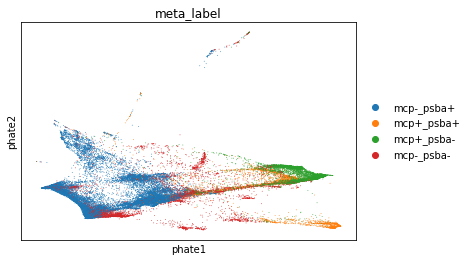

In [19]:
scanpy.external.pl.phate(adata2, color=["meta_label"])